Summary of notebook:  
Gray-world White balance is made, where overpresence of one or more colors is removed.  
Lightness is separated from the color channels. This leaves a black and white image where whiteness is the only determining factor of the image.  
Batch analysis is done, with variable batch size. Still needs to be investigated how much abstraction is acceptable.  
A heatmap for the whiteness score is made, with before and after comparison for the batch analysis.  

In [15]:
# All imports
from pathlib import Path
import warnings
from typing import Any, Tuple
import cv2
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt

Didn't really want to figure out which parts of your code load the data, so i quickly made my own. 

In [16]:
BASE: Path = Path("bleaching_data_RS")
IMG_DIR: Path = BASE / "images"
MASKS_BLEACHED_DIR: Path = BASE / "masks_bleached"
MASKS_UNBLEACHED_DIR: Path = BASE / "masks_non_bleached"


def find_mask_pairs(img_path: Path) -> tuple[Path, Any, Any] | tuple[Path, None, None]:
    """
    Group the original and mask image files based on their stem.
    The stem is the original file name without the file extension. 
    As this is the same for all 3 images, it will select them all. 

    Args:
        img_path (Path): file path of an image in the "images" folder

    Returns:
        tuple[Path, Any, Any] | tuple[Path, None, None]: tuple of file paths for all equal images (original + 2 masks)
    """
    image_stem = img_path.stem 

    bleached_path = MASKS_BLEACHED_DIR / f"{image_stem}_bleached.png"
    unbleached_path = MASKS_UNBLEACHED_DIR / f"{image_stem}_non_bleached.png"
    if bleached_path.exists() and unbleached_path.exists(): # Check that all 3 versions of the image are there, and group them
        return img_path, bleached_path, unbleached_path
    return img_path, None, None

# Build the dataset index
pairs: list[Any] = []
for img_path in IMG_DIR.glob("*.jpg"):
    img_path, bleached_path, non_bleached_path = find_mask_pairs(img_path)
    if bleached_path is None or non_bleached_path is None:  # Warning if there is a missing mask
        print(f"[WARN] Missing masks for {img_path.name}")
        continue
    pairs.append((img_path, bleached_path, non_bleached_path))

print(f"Found {len(pairs)} image/mask triplets.")

Found 658 image/mask triplets.


Underwater images typically have a blue/green cast. This could be an issue for a model, as it would get biased to this color scheme. <br>
This is fixed by creating a gray world balance, where the average color of all color channels is achromatic (so r = b = g). <br>
Merging these channels then makes it so that the average color of all pixels is gray. <br>
As shown in the side by side comparison, the green/yellow tint is removed from the image. <br>
The parts that are white IRL appear to be a red/purple-ish tint (red is boosted to make up for the excess blue/green tint). For now this may look weird, but eventually RGB colors will not matter anymore so this is not a problem.<br>

idx=11 is a good example where tint is removed without altering the image much more. idx=12 shows the red tint that is explained above.

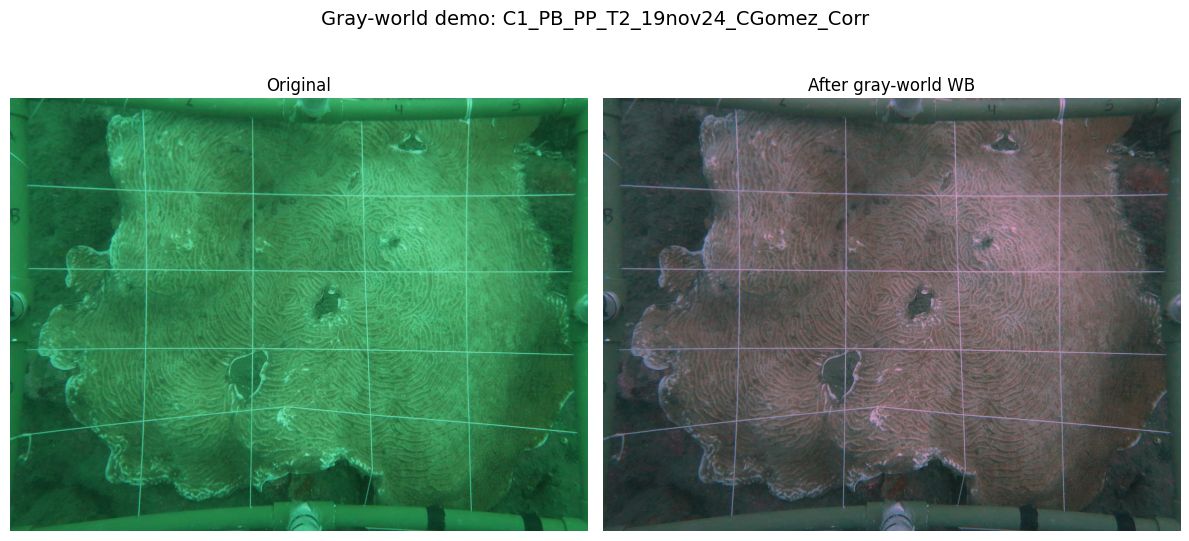

In [17]:
def gray_world_wb(bgr: npt.NDArray[np.uint8]) -> npt.NDArray[np.uint8]:
    """
    Transform any (colored) image into a gray-world WB image.

    Args:
        bgr (NDArray[np.uint8]): Array that represents all three color channels, combined
        This is before the gray-world wb transformation
    Returns:
        NDArray[np.uint8]: Array that represents all three color channels, combined.
        This is after the gray-world wb transforamtion
    """
    b, g, r = cv2.split(bgr.astype(np.float32)) # split image into color channels.
    mb, mg, mr = b.mean(), g.mean(), r.mean()   # Calculate mean value of each color channel.
    m = (mb + mg + mr) / 3.0    # Calculate global average.
    b *= m / (mb + 1e-6)    # Adjust each of the color channels.
    g *= m / (mg + 1e-6)
    r *= m / (mr + 1e-6)
    out = cv2.merge([b, g, r])  # Merge the channels back into one
    return np.clip(out, 0, 255).astype(np.uint8)


def get_bgr_path_by_idx_or_name(idx_or_name: int | str) -> Path:
    """
    Function that takes either the index or the name of an image, and gives the file path.

    Args:
        idx_or_name (int | str): Index or name of the image you want to view.

    Raises:
        ValueError: Gets raised when filename is not in dataset.

    Returns:
        Path: Path to the image you want to view.
    """
    # Either input the index or the name of the original file
    if type(idx_or_name) == int:
        img_path, _, _ = pairs[idx_or_name] # Select original image path
    elif type(idx_or_name) == str:
        stem = Path(idx_or_name).stem.lower()

        # find match in pairs
        for img_path, _, _ in pairs:
            if img_path.stem.lower() == stem:
                break
        else:
            raise ValueError(f"No image with stem '{stem}' found in dataset.")
    return img_path


def demo_gray_world(idx_or_name: int | str = 0) -> None:
    """
    Gives a side by side comparison of the gray-world white balance that is defined above.

    Args:
        idx (int | str): Index or name of the image you want to view.
    """
    img_path = get_bgr_path_by_idx_or_name(idx_or_name)
    
    img_bgr = cv2.imread(img_path)  

    # Apply gray-world white balance
    corrected_bgr = gray_world_wb(img_bgr) 

    # Convert BGR->RGB for matplotlib
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    corrected_rgb = cv2.cvtColor(corrected_bgr, cv2.COLOR_BGR2RGB) 

    # Plot side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(img_rgb)
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(corrected_rgb)
    axs[1].set_title("After gray-world WB")
    axs[1].axis("off")

    plt.suptitle(f"Gray-world demo: {img_path.stem}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Try it on some image
demo_gray_world(idx_or_name="C1_PB_PP_T2_19nov24_CGomez_Corr.JPG")

For a selected image, the image is converted into gray-world wb. Then that is split into LAB.  
LAB is a way to represent color in terms of lightness (L), and two color components (a and b).  
We will use the lightness component to show whiteness.  
  
Histogram equalization (HE) equalizes the color intensities across the entire image. Think of a histogram with the color intensities on the x axis. This could over- or under-brighten certain parts if the lighting is uneven in the image.  
That's why adaptive HE is done, where the image is split into blocks of 8x8 pixels. Each tile is equalized locally, and then stichted together.  
However, if you now have a tile that is very uniform (e.g. all pixels have a value of 50), AHE wants to stretch its very limited value range to the whole 0-255. If there is a little noise, this gets expanded into a big change.  
CLAHE introduces a cliplimit for the histogram bins. If an intensity value gets clipped, the excess is redistributed among the other bins. This way no single value has a giant peak while the others have none.  
  
After this, the adjusted lightness is added back with the color components.

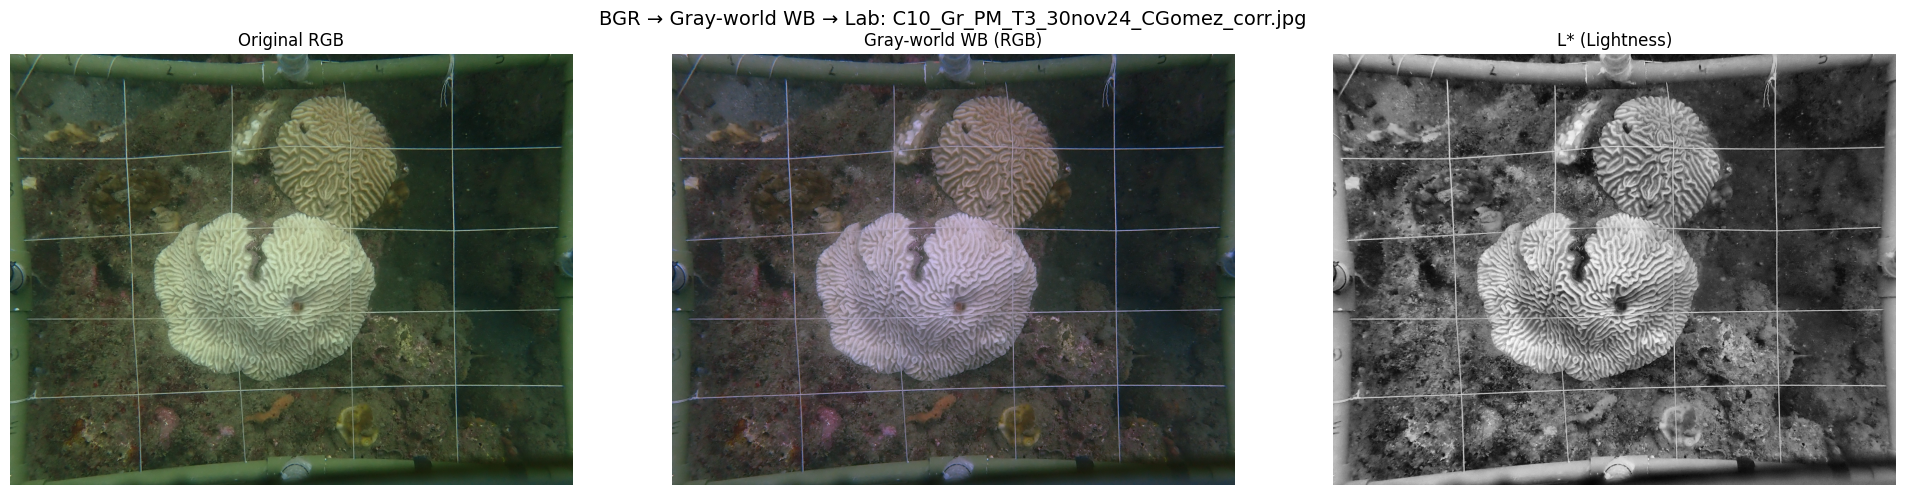

In [21]:
def bgr_to_lab(bgr: npt.NDArray[np.uint8]) -> npt.NDArray[np.uint8]:
    """
    Takes an image in BGR format, converts to LAB, applies CLAHE to L, an merges the equalized L with the original color components.

    Args:
        bgr (NDArray[np.uint8]): 3D matrix with three color channels. 

    Returns:
        NDArray[np.uint8]: 3D matrix with lightness and two color channels.
    """
    bgr = gray_world_wb(bgr) 
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB) # Convert BGR to LAB
    L, a, b = cv2.split(lab)    # Allows lightness to be used on its own.

    # Local contrast equalization with clipping to avoid noise amplification
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    L_eq = clahe.apply(L)

    lab_eq = cv2.merge([L_eq, a, b])
    return lab_eq


def demo_bgr_to_lab_with_wb(idx_or_name: int | str=0) -> None:
    """
    Show Original RGB, Gray-world WB RGB, and Lab channels (from WB image).

    Args:
        pairs: list of (img_path, mb_path, mu_path)
        name_or_idx: index (int) or filename/stem (str)
    """
    # Get image path
    img_path = get_bgr_path_by_idx_or_name(idx_or_name)

    # Get original image
    img_bgr = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Get gray-world white balance image
    gw_bgr = gray_world_wb(img_bgr)
    gw_rgb = cv2.cvtColor(gw_bgr, cv2.COLOR_BGR2RGB)

    # Get LAB image
    gw_lab = bgr_to_lab(img_bgr)
    L, a, b = cv2.split(gw_lab)

    # Plot original, GW, 
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    # fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    axs[0].imshow(img_rgb); axs[0].set_title("Original RGB"); axs[0].axis("off")
    axs[1].imshow(gw_rgb);  axs[1].set_title("Gray-world WB (RGB)"); axs[1].axis("off")
    axs[2].imshow(L, cmap="gray"); axs[2].set_title("L* (Lightness)"); axs[2].axis("off")
    # axs[3].imshow(a, cmap="gray"); axs[3].set_title("a* (Green↔Red)"); axs[3].axis("off")
    # axs[4].imshow(b, cmap="gray"); axs[4].set_title("b* (Blue↔Yellow)"); axs[4].axis("off")

    plt.suptitle(f"BGR → Gray-world WB → Lab: {img_path.name}", fontsize=14)
    plt.tight_layout()
    plt.show()


demo_bgr_to_lab_with_wb(10)

load_mask creates a boolean matrix for the masked images. So when you put the (non-)bleached mask image into here, you get a matrix where only the pixels included in the mask get a value.  
For the whiteness score, the image is first converted to LAB. Then the components of LAB are normalized:  
- L is transformed from a range of [0,255] to [0,1]  
- A and B are transformed from a range from [0,255] to [-127,127]. This way, neutral gray is at 0.  
  
After that, the chroma magnitude is calculated. This is basically a measure of colorfulness.  
  
The whiteness score is calculated by the lightness - k * colorfulness, where k is a chosen weight.  
The reason for this whiteness score definition is that multiple papers (see literature research document for exact papers) have shown that lightness of a gray-scale image corresponds to a bleached coral.  
However, color of the corals should also be taken into account. A brightly colored healthy coral may have a similar lightness to a bleached coral.  
An since chroma magnitude is directly calculated from LAB, it was the obvious choice.  
  
Lighting and color can differ across images, so robust_unit normalizes the input so they are a percentile instead of actual score. This prevents outliers from dominating the scale.  
Finally, the whiteness score is normalized in the same way. 

In [22]:
def load_mask(path: Path, target_shape: tuple[int, int], thr: int = 128) -> npt.NDArray[Any]| None:
    """
    Read grayscale mask, resize to desired shape, and return a matrix with boolean entries.
    thr >= 128 = white, which means the mask is true.

    Args:
        path (Path): Path to the image in the directory
        target_shape (tuple[int, int]): Desired image shape
        thr (int, optional): Threshold for presence/absence of mask. Defaults to 128.

    Returns:
        NDArray[Any]| None: Boolean array with mask information
    """
    mask = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        warnings.warn(f"Skipping the missing mask: {path}")
        return None
    H, W = target_shape
    if mask.shape != (H, W):
        mask = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST) # Copies the pixel value of the nearest neighbor to missing values.
    return mask >= thr



def whiteness_paleness_score(bgr: npt.NDArray[np.uint8],
                             valid_mask: npt.NDArray[np.bool_] | None = None,
                             k: float = 0.6) -> npt.NDArray[np.float32]:
    """
    Computes whiteness score per pixel within the range [0,1].
    The whiteness score is normalized using percentiles, so scores of different images can be directly compared. 

    Args:
        bgr (NDArray): 3D matrix with three color channels. 
        valid_mask (NDArray | None, optional): 2D boolean matrix . Defaults to None.
        k (float, optional): weight of colorfulness. Defaults to 0.6.

    Returns:
        NDArray: 2D matrix with whiteness score for every pixel
    """
    # Convert image to LAB (with GW step)
    lab = bgr_to_lab(bgr)
    L, a, b = cv2.split(lab)

    # Normalize components
    L_normal = L.astype(np.float32) / 255.0 # Transform to range [0,1].
    a_normal = (a.astype(np.float32) - 128.0) # Transform to range [-127, 127] with 0 being neutral gray.
    b_normal = (b.astype(np.float32) - 128.0) # Transform to range [-127, 127] with 0 being neutral gray.
    C  = np.sqrt(a_normal*a_normal + b_normal*b_normal) # Chroma magnitude

    # If no mask is selected, then the entire image is used.
    if valid_mask is None:
        valid_mask = np.ones(L_normal.shape, dtype=bool)


    # Normalizes the feature matrix to percentiles.
    def robust_unit(x: npt.NDArray[np.float32], mask: npt.NDArray[Any]) -> npt.NDArray[np.float32]:
        vals = x[mask] # Only look at pixels in the mask
        p1, p99 = np.percentile(vals, [1, 99]) # Define 1st and 99th percentile element
        return np.clip((x - p1) / (p99 - p1 + 1e-6), 0, 1) # Map values proportionally to [0,1]

    # Apply normalization to lightness and colorfulness
    Ln = robust_unit(L_normal, valid_mask) # brighter -> larger
    Cn = robust_unit(C,  valid_mask) # more colorful -> larger

    # Whiteness score
    score = Ln - k * Cn 

    # Map whiteness score to [0,1]
    sval = score[valid_mask]
    s1, s99 = np.percentile(sval, [1, 99])
    score_normal = np.clip((score - s1) / (s99 - s1 + 1e-6), 0, 1).astype(np.float32)
    return score_normal


In [ ]:
def block_mean(img: npt.NDArray[np.float32], block: int = 16) -> npt.NDArray[np.float32]:
    """
    Divide the image into non-overlapping tiles. 
    Calculate the average value of each tile.
    Create a scaled down image with the average values of each tile.

    Args:
        img (npt.NDArray[np.float32]): 2D matrix of image (possibly with GW or LAB preprocessing)
        block (int, optional): Size of the tiles. Defaults to 16.

    Returns:
        npt.NDArray[np.float32]: Scaled down version of the image after average-pooling.
    """
    HEIGHT, WIDTH = img.shape
    nr_H_tiles, nr_W_tiles = HEIGHT // block, WIDTH // block # Calculate number of tiles in both directions
    img = img[:nr_H_tiles*block, :nr_W_tiles*block] # Image is cropped to perfectly fit non-overlapping tiles
    return img.reshape(nr_H_tiles, block, nr_W_tiles, block).mean(axis=(1, 3)) # Reshape the image.



def downsample_mask(mask: npt.NDArray[np.bool_], block: int = 16) -> npt.NDArray[np.bool_]:
    """
    Divide mask image into non-overlapping tiles.
    Create a scaled down mask image with the average boolean value of each tile.

    Args:
        mask (npt.NDArray[np.bool_]): 2D boolean matrix.
        block (int, optional): Size of the tiles. Defaults to 16.

    Returns:
        npt.NDArray[np.bool_]: Scaled down version of the mask image after average-pooling.
    """
    m = block_mean(mask.astype(np.float32), block=block)
    return m > 0.5


In [24]:
import matplotlib.pyplot as plt

def overlay_heatmap(bgr: npt.NDArray, score01: npt.NDArray, alpha: float = 0.5) -> npt.NDArray:
    """
    Overlay score in [0,1] with a colormap on top of the original BGR image.
    """
    heat_rgb = (plt.cm.jet(score01)[:, :, :3] * 255).astype(np.uint8)
    heat_bgr = cv2.cvtColor(heat_rgb, cv2.COLOR_RGB2BGR)
    return cv2.addWeighted(bgr, 1 - alpha, heat_bgr, alpha, 0)

def show_and_save_quick_plots(img_bgr, score, mb, mu, out_prefix: str):
    """
    Save an overlay and a histogram comparing bleached vs unbleached pixels.
    """
    # 1) Overlay
    overlay = overlay_heatmap(img_bgr, score)
    cv2.imwrite(f"{out_prefix}_overlay.jpg", overlay)

    # 2) Histogram
    plt.figure(figsize=(6,4))
    if mu is not None and mu.any():
        plt.hist(score[mu].ravel(), bins=40, alpha=0.6, label="Unbleached")
    if mb is not None and mb.any():
        plt.hist(score[mb].ravel(), bins=40, alpha=0.6, label="Bleached")
    plt.xlabel("Whiteness/Paleness score [0,1]")
    plt.ylabel("Pixels")
    plt.title(out_prefix.split('/')[-1] + " — score histogram")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{out_prefix}_hist.png", dpi=150)
    plt.close()


In [ ]:
import pandas as pd
from pathlib import Path

OUT_DIR = Path("outputs")
(OUT_DIR / "overlays").mkdir(parents=True, exist_ok=True)

def safe_stats(arr: npt.NDArray) -> tuple[float, float]:
    return float(arr.mean()), float(arr.std())

def process_one_triplet(img_path: Path, mb_path: Path, mu_path: Path,
                        k: float = 0.6, block: int = 16):
    """
    Compute per-pixel score, block means, and summary stats for one image.
    Saves overlay + histogram. Returns a dict of stats.
    """
    img = cv2.imread(str(img_path))
    H, W = img.shape[:2]

    # load masks and union for robust scaling in Step 3
    mb = load_mask(mb_path, (H, W))
    mu = load_mask(mu_path, (H, W))
    valid = (mb | mu) if (mb is not None and mu is not None) else None

    # whiteness/paleness (Step 3)
    score = whiteness_paleness_score(img, valid_mask=valid, k=k)

    # block-level
    score_b = block_mean(score, block=block)
    mb_b = downsample_mask(mb, block=block) if mb is not None else None
    mu_b = downsample_mask(mu, block=block) if mu is not None else None

    # pixel-level stats
    if mb is not None and mb.any():
        mean_b, std_b = safe_stats(score[mb])
    else:
        mean_b, std_b = np.nan, np.nan
    if mu is not None and mu.any():
        mean_u, std_u = safe_stats(score[mu])
    else:
        mean_u, std_u = np.nan, np.nan

    # simple separability (d-prime)
    if np.isfinite([mean_b, std_b, mean_u, std_u]).all():
        dprime = (mean_b - mean_u) / (np.sqrt((std_b**2 + std_u**2) / 2.0 + 1e-6))
    else:
        dprime = np.nan

    # outputs
    stem = img_path.stem
    out_prefix = str(OUT_DIR / "overlays" / stem)
    show_and_save_quick_plots(img, score, mb, mu, out_prefix)

    return dict(
        image=stem,
        mean_bleached=mean_b, std_bleached=std_b,
        mean_unbleached=mean_u, std_unbleached=std_u,
        dprime=dprime,
        block=block, k=k
    )

# ---- run on a small subset first (proof of concept) ----
rows = []
N = min(10, len(pairs))  # try 10 images first
for i in range(N):
    img_path, mb_path, mu_path = pairs[i]
    stats = process_one_triplet(img_path, mb_path, mu_path, k=0.6, block=16)
    rows.append(stats)

df = pd.DataFrame(rows)
df.to_csv(OUT_DIR / "summary_poc.csv", index=False)

print(df.head())
print(f"Saved overlays & histograms in: {OUT_DIR/'overlays'}")
print(f"Saved summary CSV: {OUT_DIR/'summary_poc.csv'}")


                                  image  mean_bleached  std_bleached  \
0       C10_BC_PM_T1_29nov24_CDaza_corr       0.684357      0.146210   
1       C10_BC_PM_T2_29nov24_CDaza_corr       0.540671      0.215951   
2       C10_BC_PM_T3_29nov24_CDaza_corr       0.581355      0.168361   
3  C10_BC_PP_T1_29nov24_HBenavides_corr       0.456842      0.217451   
4  C10_BC_PP_T2_29nov24_HBenavides_corr       0.532760      0.234786   

   mean_unbleached  std_unbleached    dprime  block    k  
0         0.370246        0.218757  1.688255     16  0.6  
1         0.305925        0.205085  1.114707     16  0.6  
2         0.423526        0.218460  0.809262     16  0.6  
3         0.506937        0.271416 -0.203702     16  0.6  
4         0.380128        0.230157  0.656525     16  0.6  
Saved overlays & histograms in: outputs\overlays
Saved summary CSV: outputs\summary_poc.csv


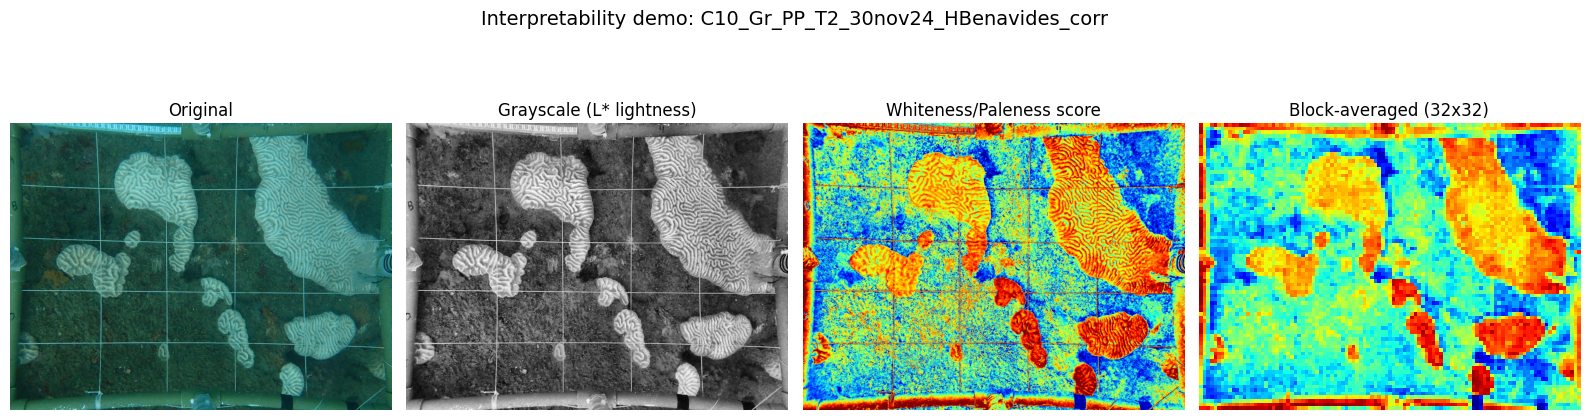

In [30]:
import random
import matplotlib.pyplot as plt

def demo_interpretability(pairs, idx, block=16, k=0.6):
    # 1) pick a random image triplet
    img_path, mb_path, mu_path = pairs[idx]
    img = cv2.imread(str(img_path))
    H, W = img.shape[:2]

    # 2) load masks just to define valid area
    mb = load_mask(mb_path, (H, W))
    mu = load_mask(mu_path, (H, W))
    valid = (mb | mu) if (mb is not None and mu is not None) else None

    # 3) preprocess to Lab (for grayscale L*)
    lab = bgr_to_lab(img)
    L, _, _ = cv2.split(lab)
    L_gray = cv2.cvtColor(cv2.merge([L,L,L]), cv2.COLOR_LAB2BGR)  # just for visualization

    # 4) whiteness/paleness score [0,1]
    score = whiteness_paleness_score(img, valid_mask=valid, k=k)

    # 5) block-averaged (batched)
    score_b = block_mean(score, block=block)

    # --- plotting ---
    fig, axs = plt.subplots(1, 4, figsize=(16, 5))

    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original"); axs[0].axis("off")

    axs[1].imshow(L, cmap="gray")
    axs[1].set_title("Grayscale (L* lightness)"); axs[1].axis("off")

    axs[2].imshow(score, cmap="jet")
    axs[2].set_title("Whiteness/Paleness score"); axs[2].axis("off")

    axs[3].imshow(score_b, cmap="jet")
    axs[3].set_title(f"Block-averaged ({block}x{block})"); axs[3].axis("off")

    plt.suptitle(f"Interpretability demo: {img_path.stem}", fontsize=14)
    plt.tight_layout()
    plt.show()

# --- run demo on one random image ---
demo_interpretability(pairs, idx=12, block=32, k=0.6)


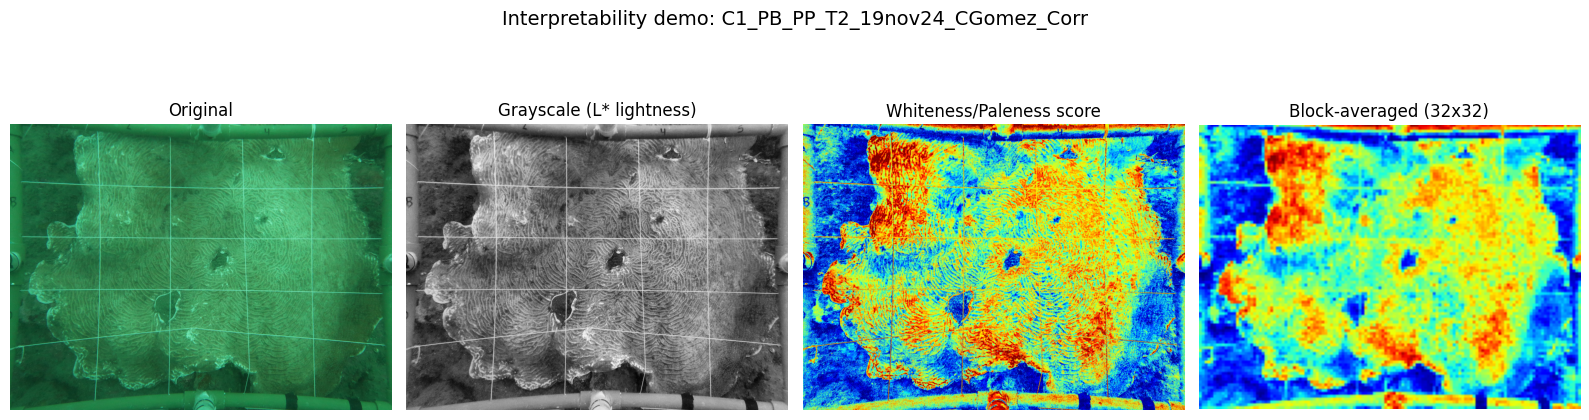

In [31]:
target = "C1_PB_PP_T2_19nov24_CGomez_Corr.JPG"  # or "IMG_0123"
stem = Path(target).stem.lower()
idx = next(i for i,(p,_,_) in enumerate(pairs) if p.stem.lower() == stem)
demo_interpretability(pairs, idx=idx, block=32, k=0.6)
